### Проект по исследованию и предсказанию цен на новостройки на основе базы данных с ЦИАН

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import scipy
import random
import folium
from geopy.geocoders import Nominatim


%matplotlib inline
sns.set()

In [2]:
# !pip install geopy

In [3]:
# Изменить текущую директорию на главную
os.chdir('..')

---
### 1. Загрузка и исследование данных

In [21]:
data_name = '2019-10-13_ciannovostroyki.csv'
data_path = os.path.join('data', data_name)

with open(data_path, 'r') as file:
    for i in range(2):
        print(file.readline())

sep=;

Код;Категория;Название;Тип продажи;Объект продажи;Общая площадь;Жилая площадь;Площадь кухни;Этаж;Этажей в доме;Лифт пассажирский (кол-во);Лифт грузовой (кол-во);Год строительства;Балкон/лоджия;Мусоропровод;Телефон;Парковка;Количество комнат;Тип дома;Название дома (ЖК);Высота потолков;Кол-во раздельных санузлов;Кол-во совмещенных санузлов;Ремонт;Вид из окон;Расстояние до метро;Кол-во квартир в доме;Адрес;Текст объявления;Стоимость;Id Пользователя;ФИО продавца;Телефон продавца;Признак актуальности;Ссылка на объявление;Ссылки на картинки;Дата обновления;Регион Циан



In [22]:
cian_data_all = pd.read_csv(data_path, sep=';', skiprows=1, encoding='cp1251')
cian_data_all.head(3)

,Код,Категория,Название,Тип продажи,Объект продажи,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Этажей в доме,...,Текст объявления,Стоимость,Id Пользователя,ФИО продавца,Телефон продавца,Признак актуальности,Ссылка на объявление,Ссылки на картинки,Дата обновления,Регион Циан
0,12034729,Недвижимость в Ногинске/Продажа/Продажа 1-комн...,"1-комн. квартира, 42.2 м2","Свободная продажа, Возможна ипотека",Новостройка,"=""42.2""","=""19.9""","=""11.0""",2,3,...,Продается однокомнатная квартира в новостройке...,2850000,277143.0,NaN,7.965219e+10,Опубликовано,https://noginsk.cian.ru/sale/flat/12034729/,https://cdn-p.cian.site/images/4/892/911/novos...,08.10.2019 13:56:39,Богородский
1,12695191,Недвижимость в Москве/Продажа/Продажа 2-комнат...,"2-комн. квартира, 70.03 м2",", Возможна ипотека",Новостройка,"=""70.03""","=""41.8""","=""13.7""",2,17,...,Продается просторная двухкомнатная квартира 70...,7073030,389766.0,ИНКОМ-Новостройки,7.495163e+10,Опубликовано,https://www.cian.ru/sale/flat/12695191/,https://cdn-p.cian.site/images/3/824/736/novos...,11.10.2019 9:25:04,Москва
2,12722545,Недвижимость в Москве/Продажа/Продажа 3-комнат...,"3-комн. квартира, 76.47 м2",", Возможна ипотека",Новостройка,"=""76.47""","=""43.4""","=""11.2""",11,17,...,"Продается трехкомнатная квартира 76,47 кв.м с ...",7799940,389766.0,ИНКОМ-Новостройки,7.495163e+10,Опубликовано,https://www.cian.ru/sale/flat/12722545/,https://cdn-p.cian.site/images2/5/690/176/novo...,11.10.2019 6:45:06,Москва


Размеры данных и количество дубликатов

In [23]:
cian_data_all.shape

(37400, 38)

In [24]:
cian_data_all.duplicated().sum()

93

In [25]:
cian_data_all.drop_duplicates(inplace=True)

Общая информация

In [26]:
cian_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37307 entries, 0 to 37399
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Код                          37307 non-null  int64  
 1   Категория                    37307 non-null  object 
 2   Название                     37307 non-null  object 
 3   Тип продажи                  36703 non-null  object 
 4   Объект продажи               37307 non-null  object 
 5   Общая площадь                37307 non-null  object 
 6   Жилая площадь                37307 non-null  object 
 7   Площадь кухни                37307 non-null  object 
 8   Этаж                         37307 non-null  int64  
 9   Этажей в доме                37307 non-null  int64  
 10  Лифт пассажирский (кол-во)   35891 non-null  float64
 11  Лифт грузовой (кол-во)       35610 non-null  float64
 12  Год строительства            257 non-null    float64
 13  Балкон/лоджия   

Доля пропущенных

In [27]:
(cian_data_all.isna().sum() / cian_data_all.shape[0]) * 100 

Код                              0.000000
Категория                        0.000000
Название                         0.000000
Тип продажи                      1.618999
Объект продажи                   0.000000
Общая площадь                    0.000000
Жилая площадь                    0.000000
Площадь кухни                    0.000000
Этаж                             0.000000
Этажей в доме                    0.000000
Лифт пассажирский (кол-во)       3.795534
Лифт грузовой (кол-во)           4.548744
Год строительства               99.311121
Балкон/лоджия                   81.679041
Мусоропровод                     0.000000
Телефон                          0.000000
Парковка                        11.413408
Количество комнат                6.497440
Тип дома                         0.694240
Название дома (ЖК)               0.544134
Высота потолков                 55.817943
Кол-во раздельных санузлов      22.419385
Кол-во совмещенных санузлов    100.000000
Ремонт                          98

Признаки, в которых содержится более 80% пропущенных значений, удалим из данных и сохраним отдельный файл

In [28]:
missing_percents = (cian_data_all.isna().sum() / cian_data_all.shape[0]) * 100
drop_columns = missing_percents[missing_percents > 80].index.to_list()

Количество уникальных значений в признаках (всего 37400 строк)

In [29]:
for colname in cian_data_all.columns:
    print(f'{colname} : {len(cian_data_all[colname].unique())}')

Код : 37307
Категория : 3650
Название : 7211
Тип продажи : 8
Объект продажи : 2
Общая площадь : 4603
Жилая площадь : 731
Площадь кухни : 371
Этаж : 68
Этажей в доме : 65
Лифт пассажирский (кол-во) : 13
Лифт грузовой (кол-во) : 13
Год строительства : 58
Балкон/лоджия : 3
Мусоропровод : 2
Телефон : 2
Парковка : 4
Количество комнат : 7
Тип дома : 6
Название дома (ЖК) : 777
Высота потолков : 67
Кол-во раздельных санузлов : 6
Кол-во совмещенных санузлов : 1
Ремонт : 5
Вид из окон : 4
Расстояние до метро : 139
Кол-во квартир в доме : 343
Адрес : 2340
Текст объявления : 27209
Стоимость : 30013
Id Пользователя : 2800
ФИО продавца : 1146
Телефон продавца : 2921
Признак актуальности : 3
Ссылка на объявление : 37307
Ссылки на картинки : 33055
Дата обновления : 11467
Регион Циан : 60


Данные имеют много мусора, требуются преобразование признаков. 
93 дубликата из 37400

Более 80% информации отсутствует по признакам:
* Кол-во квартир в доме
* Ремонт
* Кол-во совмещенных санузлов
* Год строительства
* Балкон/лоджия

Малоинформативные признаки
* Код
* Ссылки на картинки
* Ссылка на объявление
* Текст объявления
* Телефон продавца
* Телефон
* ФИО продавца
* Id Пользователя
* Категория
* Название

Эти столбцы удалим  
Из некоторых других признаков можно вытащить полезную числовую информацию

In [30]:
drop_columns.extend(['Код', 'Ссылки на картинки', 'Ссылка на объявление', 
                     'Текст объявления', 'Телефон продавца', 'Телефон', 
                     'ФИО продавца', 'Id Пользователя', 'Категория', 'Название',
                     'Тип продажи', 'Жилая площадь', 'Площадь кухни', 'Мусоропровод',
                     'Лифт пассажирский (кол-во)', 'Лифт грузовой (кол-во)',
                     'Кол-во раздельных санузлов', 'Название дома (ЖК)', 
                     'Признак актуальности', 'Регион Циан'
#                      'Стоимость'
                    ])

In [31]:
cian_data_all[drop_columns].to_csv(os.path.join('data', 'dropped_cian_data_filled.csv'))
cian_data_all.drop(drop_columns, axis=1, inplace=True)

In [32]:
cian_data_all.columns

Index(['Объект продажи', 'Общая площадь', 'Этаж', 'Этажей в доме', 'Парковка',
       'Количество комнат', 'Тип дома', 'Высота потолков', 'Вид из окон',
       'Расстояние до метро', 'Адрес', 'Стоимость', 'Дата обновления'],
      dtype='object')

In [33]:
cian_data_all.to_csv(os.path.join('data', 'all_cian_data.csv'))

In [34]:
cian_data_all = pd.read_csv(os.path.join('data', 'all_cian_data.csv'), index_col=0)

In [35]:
y = cian_data_all['Стоимость']
X = cian_data_all.drop('Стоимость', axis=1)

---
### 2. Исследование признаков

In [36]:
X.head().T

,0,1,2,3,4
Объект продажи,Новостройка,Новостройка,Новостройка,Новостройка,Новостройка
Общая площадь,"=""42.2""","=""70.03""","=""76.47""","=""60.0""","=""65.2"""
Этаж,2,2,11,5,2
Этажей в доме,3,17,17,20,5
Парковка,NaN,подземная,подземная,NaN,подземная
Количество комнат,1,2,3,2,2
Тип дома,Кирпичный,Монолитный,Монолитный,Монолитный,Монолитный
Высота потолков,NaN,NaN,NaN,NaN,NaN
Вид из окон,Во двор,NaN,Во двор,На улицу и двор,На улицу и двор
Расстояние до метро,NaN,12 мин. на транспорте,12 мин. на транспорте,3 мин. на транспорте,NaN


In [37]:
X.columns

Index(['Объект продажи', 'Общая площадь', 'Этаж', 'Этажей в доме', 'Парковка',
       'Количество комнат', 'Тип дома', 'Высота потолков', 'Вид из окон',
       'Расстояние до метро', 'Адрес', 'Дата обновления'],
      dtype='object')

---
### Объект продажи

In [38]:
X['Объект продажи'].value_counts()

Новостройка    36848
Вторичка         459
Name: Объект продажи, dtype: int64

In [39]:
X['Объект продажи'].isna().sum()

0

Явный дисбаланс, вторичек почти нет, для предсказания стоимости вторичек недостаточно данных. Поэтому сосредоточимся на предсказании стоимости новостроек.

In [40]:
y[X.index]

0         2850000
1         7073030
2         7799940
3        11700000
4         6055000
           ...   
37395     4312500
37396     5102860
37397     5376000
37398     7000000
37399     4144470
Name: Стоимость, Length: 37307, dtype: int64

In [41]:
X = X[X['Объект продажи'] == 'Новостройка']
y = y[X.index]

---
### Общая площадь

In [42]:
X['Общая площадь'] = X['Общая площадь'].str.strip('=\"').astype('float')

In [43]:
X['Общая площадь'].isna().sum()

0

<AxesSubplot:xlabel='Общая площадь', ylabel='Count'>

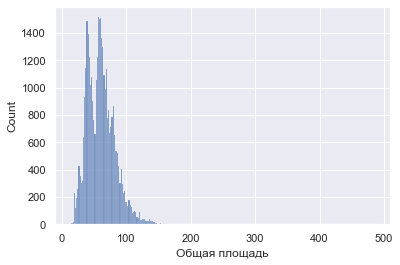

In [44]:
sns.histplot(x=X['Общая площадь'])

<AxesSubplot:xlabel='Общая площадь'>

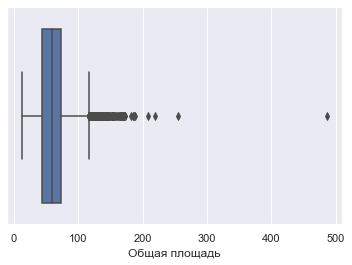

In [45]:
sns.boxplot(x=X['Общая площадь'])

Распределение по площади отличается от нормального, также имеется много выбросов
Удалим сразу явный выброс

In [46]:
 X['Общая площадь'].quantile(0.995)

135.37649999999994

In [47]:
quantile_005 = X['Общая площадь'].quantile(0.995)
X = X[X['Общая площадь'] <= quantile_005]
y = y[X.index]

---
### Этаж и этажей в доме

In [48]:
X['Этаж'].isna().sum()

0

In [49]:
X['Этажей в доме'].isna().sum()

0

<AxesSubplot:xlabel='Этаж', ylabel='Count'>

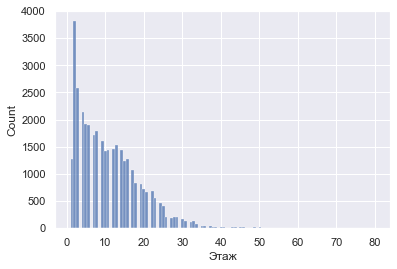

In [50]:
sns.histplot(X['Этаж'])

<AxesSubplot:xlabel='Этажей в доме', ylabel='Count'>

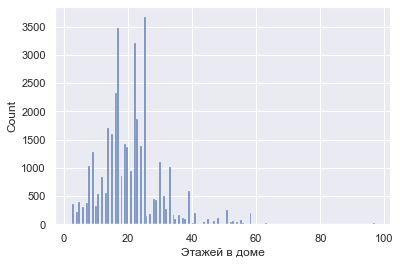

In [51]:
sns.histplot(X['Этажей в доме'])

<AxesSubplot:xlabel='Этаж', ylabel='Стоимость'>

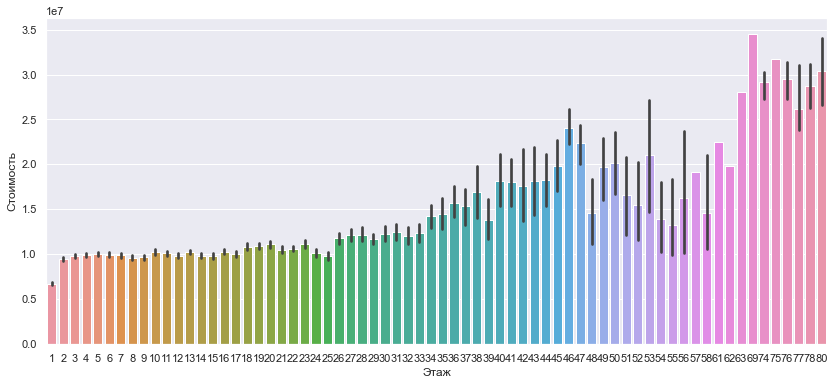

In [52]:
plt.figure(figsize=(14, 6))
sns.barplot(x=X['Этаж'], y=y)

<AxesSubplot:xlabel='Этажей в доме', ylabel='Стоимость'>

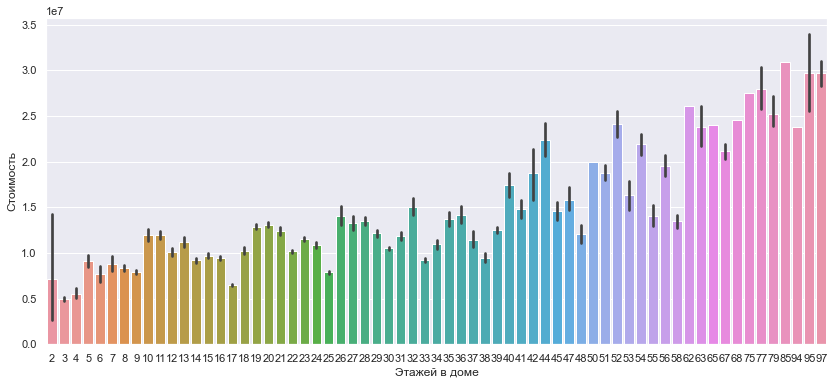

In [53]:
plt.figure(figsize=(14, 6))
sns.barplot(x=X['Этажей в доме'], y=y)

Чем выше этаж и чем больше этажей в доме, тем выше средняя стоимость квартиры.  
Явно дешевле 1 этаж. Похоже, что последние этажи в доме тоже дешевле (17, 25, 33,...)
Визульное разделение на 1, 2-17, 18-25, 26-33, 33-...  

(0.0, 50000000.0)

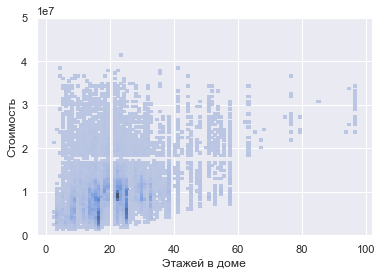

In [54]:
ax = sns.histplot(x=X.loc[:, 'Этажей в доме'], y=y[:], bins=100)
ax.set_ylim((0, 0.5e8))

Самый высокий жилой дом в подмосковье - 54 этажа, как правило из многоэтажек 27-30, 44-45 этажей

Можно сосредоточиться на таких домах. Выше - это элитное жилье.

In [56]:
mask = X['Этажей в доме'] <= 60

X = X[mask]
y = y[mask]

---
### Парковка

In [57]:
X['Парковка'].value_counts()

подземная     15423
Неизвестно    15114
Наземная       2127
Name: Парковка, dtype: int64

In [58]:
X['Парковка'].isna().sum()

3937

In [59]:
X['Парковка'] = X['Парковка'].fillna('Неизвестно')

In [60]:
mask = X['Парковка'] == 'подземная'

X.loc[mask, 'Парковка'] = 'Подземная'

<AxesSubplot:xlabel='Парковка', ylabel='Стоимость'>

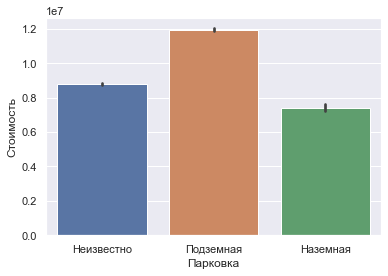

In [62]:
X['Парковка']
sns.barplot(x=X['Парковка'], y=y)

(0.0, 40000000.0)

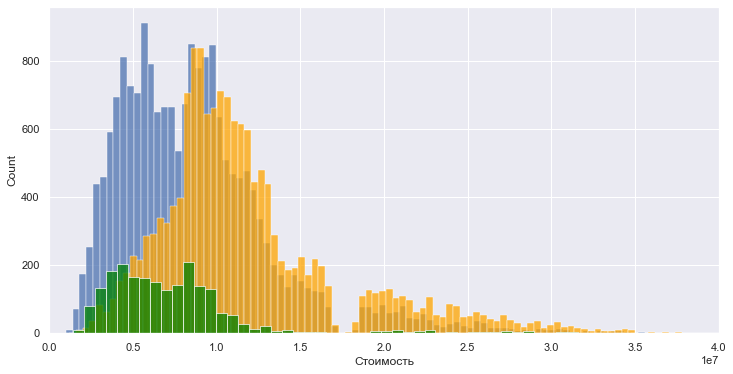

In [63]:
mask_1 = X['Парковка'] == 'Неизвестно'
mask_2 = X['Парковка'] == 'Подземная'
mask_3 = X['Парковка'] == 'Наземная'

plt.figure(figsize=(12, 6))
ax = sns.histplot(y[mask_1])
sns.histplot(y[mask_2], ax=ax, color='orange')
sns.histplot(y[mask_3], ax=ax, color='green')
ax.set_xlim((0, 0.4e8))

Наличие подземной парковки скорее всего увеличивает среднюю стоимость квартиры

Типов парковки немного, можно использовать dummy кодирование для наземной, подземной и если неизвестно о парковке

---
### Количество комнат

In [64]:
X['Количество комнат'].isna().sum()

2385

Text(0.5, 1.0, 'Площадь квартир с пропущенным значением кол-ва комнат')

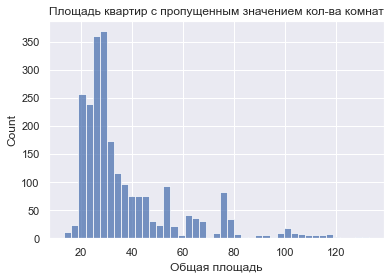

In [65]:
ax = sns.histplot(x=X[X['Количество комнат'].isna()]['Общая площадь'])
ax.set_title('Площадь квартир с пропущенным значением кол-ва комнат')

<AxesSubplot:xlabel='Общая площадь', ylabel='Количество комнат'>

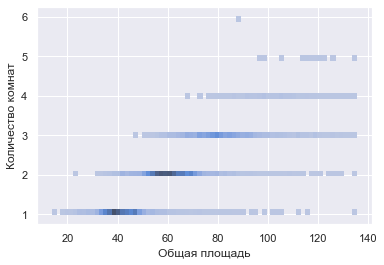

In [66]:
mask = X['Количество комнат'].isna()

sns.histplot(x=X['Общая площадь'], y=X['Количество комнат'])

Можно заполнять пропущенные значения количества комнат в соответствии со значением площади. Но тогда получится линейная зависимость. Поэтому для простоты сначала будем заполнять пропущенные значения на медианное значение - 2 комнаты.

In [53]:
median = X['Количество комнат'].median()
X['Количество комнат'] = X['Количество комнат'].fillna(median)

---
### Тип дома

In [80]:
X['Тип дома'].isna().sum()

131

In [81]:
X['Тип дома'].value_counts()

Монолитный             31973
Панельный               3666
Кирпичный                574
Монолитно-кирпичный      257
Name: Тип дома, dtype: int64

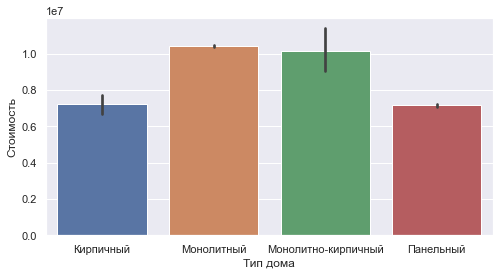

In [68]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=X['Тип дома'], y=y)

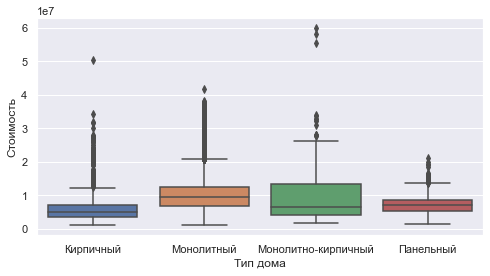

In [56]:
plt.figure(figsize=(8, 4))
ax = sns.boxplot(x=X['Тип дома'], y=y)

In [69]:
X['Тип дома'].unique()

array(['Кирпичный', 'Монолитный', nan, 'Монолитно-кирпичный', 'Панельный'],
      dtype=object)

<AxesSubplot:xlabel='Стоимость', ylabel='Density'>

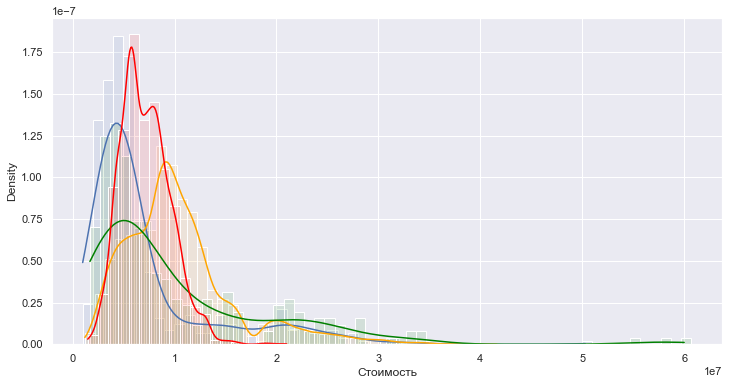

In [107]:
mask_1 = X['Тип дома'] == 'Кирпичный'
mask_2 = X['Тип дома'] == 'Монолитный'
mask_3 = X['Тип дома'] == 'Монолитно-кирпичный'
mask_4 = X['Тип дома'] == 'Панельный'

plt.figure(figsize=(12, 6))
ax = sns.histplot(y[mask_1], binwidth=0.1e7, stat='density', alpha=0.1, kde=True)
sns.histplot(y[mask_2], ax=ax, binwidth=0.1e7, color='orange', stat='density', alpha=0.1, kde=True)
sns.histplot(y[mask_3], ax=ax, binwidth=0.1e7, color='green', stat='density', alpha=0.1, kde=True)
sns.histplot(y[mask_4], ax=ax, binwidth=0.1e7, color='red', stat='density', alpha=0.1, kde=True)
# ax.set_xlim((0, 0.4e8))

In [98]:
X['Тип дома'].mode().values[0]

'Монолитный'

In [108]:
mode = X['Тип дома'].mode().values[0]
X['Тип дома'] = X['Тип дома'].fillna(mode)

Тип дома визуально заметно влияет на стоимость квартиры. Типов немного, можно использовать dummy-кодирование

---
### Высота потолков

In [109]:
X['Высота потолков'].isna().sum()

20339

<AxesSubplot:xlabel='Высота потолков', ylabel='Count'>

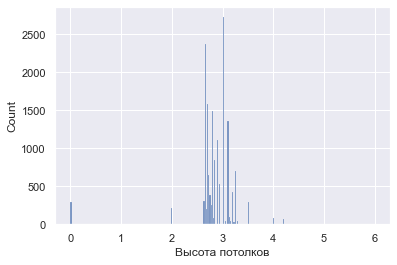

In [110]:
sns.histplot(X['Высота потолков'])

Очень много пропущенных и незаполненных значений. 

Высота потолком менее метра выглядит как неправильные данные. Можно сделать категории, например: неизвестно, <=2.5 м, 2.5-3м, >3 м

In [111]:
X['Высота потолков'] = X['Высота потолков'].fillna(0)

In [112]:
X_dummy_hight = pd.get_dummies(
    pd.cut(X['Высота потолков'],
       bins=[0, 2.5, 3, 6],
       include_lowest=True,
       labels=['Высота неизвестна', 'Высота менее 2.5-3 м', 'Высота более 3 м']
    )
)

In [113]:
X = X.join(X_dummy_hight)

---
### Вид из окон

In [115]:
X['Вид из окон'].isna().sum()

19396

In [116]:
X['Вид из окон'].unique()

array(['Во двор', nan, 'На улицу и двор', 'На улицу'], dtype=object)

<AxesSubplot:xlabel='Вид из окон', ylabel='Стоимость'>

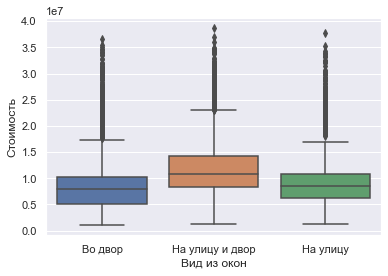

In [117]:
sns.boxplot(x=X['Вид из окон'], y=y)

Очень много пропущенных значений. Скорее всего, вид на улицу и двор означает, что квартира большая. А значит и медианная стоимость будет больше. Сам по себе признак малоинформативен.

Можно добавить бинарный признак, вид "на улицу и двор" или нет

<AxesSubplot:xlabel='Стоимость', ylabel='Density'>

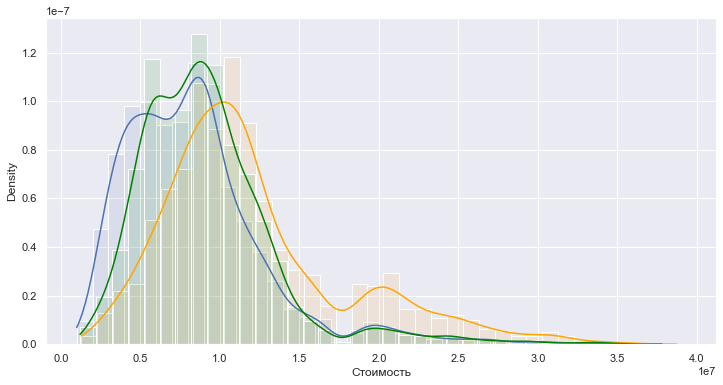

In [118]:
mask_1 = X['Вид из окон'] == 'Во двор'
mask_2 = X['Вид из окон'] == 'На улицу и двор'
mask_3 = X['Вид из окон'] == 'На улицу'

plt.figure(figsize=(12, 6))
ax = sns.histplot(y[mask_1], binwidth=0.1e7, stat='density', alpha=0.1, kde=True)
sns.histplot(y[mask_2], ax=ax, binwidth=0.1e7, color='orange', stat='density', alpha=0.1, kde=True)
sns.histplot(y[mask_3], ax=ax, binwidth=0.1e7, color='green', stat='density', alpha=0.1, kde=True)

In [119]:
X['Вид из окон'] = X['Вид из окон'].map(lambda row: 1 if row == 'На улицу и двор' else 0)

---
### Расстояние до метро

In [120]:
X['Расстояние до метро'].isna().sum()

1842

In [121]:
X['Расстояние до метро'].str.split('.', expand=True)

,0,1
0,NaN,NaN
1,12 мин,на транспорте
2,12 мин,на транспорте
3,3 мин,на транспорте
4,NaN,NaN
...,...,...
37395,NaN,NaN
37396,23 мин,на транспорте
37397,NaN,NaN
37398,NaN,NaN


Расстояние до метро должно влиять на цену квартиры, но время может быть как пешком, так и на транспорте. Необходимо привести к единой величине. Скорее всего у распределения будет хвост, причем далее ~20-30 минут пешком расстояние слабее должно влиять на стоимость. 
Таким образом, зависимоть цены от расстояния должно быть ~ экспоненциальной

Будем использовать следующее преобразование:  
    Отделим пропущенные значения  
    Приведём к единой системе измерений - **расстояние до метро в метрах**  

Для этого время пешком умножим на среднюю скорость человека, а время на транпорте умножим на некоторую среднюю скорость транпорта

Среднюю скорость движения автобусов возьмем около 40 км/ч

In [122]:
X['Расстояние до метро'].str.split('.', expand=True)

,0,1
0,NaN,NaN
1,12 мин,на транспорте
2,12 мин,на транспорте
3,3 мин,на транспорте
4,NaN,NaN
...,...,...
37395,NaN,NaN
37396,23 мин,на транспорте
37397,NaN,NaN
37398,NaN,NaN


In [123]:
X_sub_distance = X['Расстояние до метро'].str.split('.', expand=True)
X_sub_distance_time = X_sub_distance[0].str.rstrip(' мин').astype(float)
X_sub_distance_time.name = 'Время до метро'

# Save 1/0 filter mask 
mask = X_sub_distance_time.isna()
mask.name = 'Пропущено время'

In [124]:
X_sub_distance.columns = 'Время', 'Тип маршрута'
X_sub_distance['Время'] = (X_sub_distance['Время'][~mask]
     .map(lambda x: int(x.split(' ')[0])))

In [125]:
def calculate_distance_to_sub(row, human_speed=5, bus_speed=40):
    """Функция переводит время до метро в расстояние"""
    
    if row.isna().any():
        return np.nan
    else:
        if row['Тип маршрута'].strip() == 'пешком':
            return row['Время'] * human_speed
        elif row['Тип маршрута'].strip() == 'на транспорте':
            return row['Время'] * bus_speed

In [126]:
X_sub_distance['Расстояние до метро'] = X_sub_distance.apply(
    calculate_distance_to_sub, axis=1)

In [127]:
X_sub_distance

,Время,Тип маршрута,Расстояние до метро
0,NaN,NaN,NaN
1,12.0,на транспорте,480.0
2,12.0,на транспорте,480.0
3,3.0,на транспорте,120.0
4,NaN,NaN,NaN
...,...,...,...
37395,NaN,NaN,NaN
37396,23.0,на транспорте,920.0
37397,NaN,NaN,NaN
37398,NaN,NaN,NaN


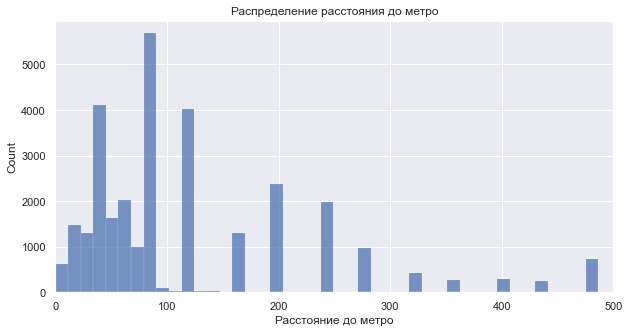

In [128]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(X_sub_distance['Расстояние до метро'])
ax.set_xlim(0, 500)
ax.set_title('Распределение расстояния до метро')
plt.show()

<AxesSubplot:xlabel='Расстояние до метро', ylabel='Стоимость'>

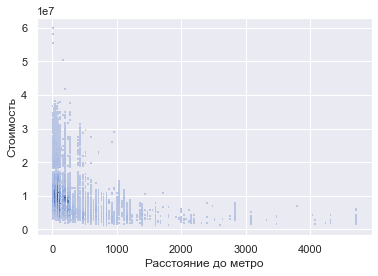

In [129]:
sns.histplot(x=X_sub_distance['Расстояние до метро'], y=y)

[8.78223984e+06 3.26351157e-03 4.69136386e+06]


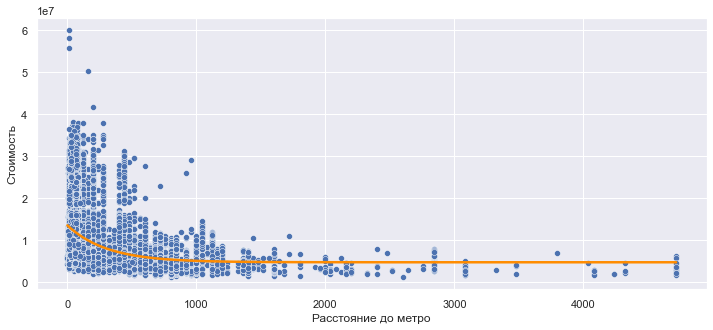

In [130]:
def fit_time_to_sub(x, a, b, c):
    return a * np.exp(-b * x) + c


mask = ~X_sub_distance['Расстояние до метро'].isna()
p0 = (3 * 10**7, 0.001, 0.1 * 10**7)

pars, _ = scipy.optimize.curve_fit(
    fit_time_to_sub, 
    xdata=X_sub_distance.loc[mask, 'Расстояние до метро'],  
    ydata=y[mask], 
    p0=p0)
print(pars)

plt.figure(figsize=(12,5))
ax = sns.lineplot(
    x=X_sub_distance['Расстояние до метро'],
    y=fit_time_to_sub(X_sub_distance['Расстояние до метро'], *pars),
    color='darkorange',
    linewidth=2.5)
sns.scatterplot(x=X_sub_distance['Расстояние до метро'], y=y, ax=ax)
ax.set_ylabel('Стоимость')
plt.show()

Для решающих деревьев используем расстояние до метро, для линейных моделей воспользуемся нелинейной функцией 

Будем считать, что если значение пропущено, значит оно не важно. То есть расстояние до метро значительное.
Заполним пропущенные значения каким-то значением из хвоста распределения

In [131]:
left_border = X_sub_distance['Расстояние до метро'].quantile(0.99)
right_border = X_sub_distance['Расстояние до метро'].max()

X['Расстояние до метро'] = X_sub_distance['Расстояние до метро'].map(
    lambda row: random.randint(left_border, right_border) if pd.isna(row) else row)

In [132]:
X['Стоимость от расстояния'] = X['Расстояние до метро'].map(lambda x, pars=pars: fit_time_to_sub(x, *pars))

---
### Адрес

In [133]:
X['Адрес'].isna().sum()

0

Адрес в чистом видео малоинформативен. Используем географическое преобразование для определение примерной геокоординаты на основе адреса

Запрос занимает значительное время, для ускорения процесса попробуем использовать геокоординаты не дома, а улицы. А также сперва составим словарь улиц.

In [134]:
def cut_ending(string):
    return ','.join(string.split(',')[:-1])

def get_location(address):
        
    geolocator = Nominatim(user_agent="moscow")
    
    try:
        location = geolocator.geocode(address).raw
        return float(location['lat']), float(location['lon']) 
    except:
        # print(f'Error for {address}')
        if not address:
            return np.nan
        return get_location(cut_ending(address))
    
def get_locations_from_addresses(addresses, verbose=50):
    
    max_len = len(addresses)
    locations = dict()
    for index, address in enumerate(addresses):
        location = get_location(address)
        locations[address] = location
        
        if index % verbose == 0:
            print("{:.1}%".format(index*100/max_len)) 
            
    return locations

In [135]:
X_address_cut = X['Адрес'].map(cut_ending)
unique_address = X_address_cut.unique()

около тысячи запросов уже гораздо лучше, чем 37 тысяч

In [136]:
# %%time

# locations = get_locations_from_addresses(unique_address)

In [137]:
# TODO добавить преобразование адреса в геолокацию
# X_locations = X_address_cut.map(lambda row: locations[row])

In [138]:
# X_locations.to_csv(os.path.join('data', 'locations.csv'))

Сохраним данные в файл, чтобы не перезапускать функцию преобразования заново

In [139]:
X_locations = pd.read_csv(os.path.join('data', 'locations.csv'), index_col=0)

In [140]:
def location_from_string(row):
    """Функция для преобразования строки в широту и долготу"""
    
    lat, lng = (row).split(',')
    lat = float(lat.replace('(', '').strip())
    lng = float(lng.replace(')', '').strip())
    return lat, lng

In [141]:
X_locations['Адрес'] = X_locations['Адрес'].map(location_from_string)

In [142]:
def get_distance(latitude, longitude, 
                 lat_center=55.7522, 
                 lng_center=37.6156):
    
    distance = np.sqrt(((latitude - lat_center)**2 + (longitude - lng_center)**2))
    
    return distance

In [143]:
X_locations.head()

,Адрес
0,"(55.7194613, 38.2175991)"
1,"(55.5501575, 37.38737943265081)"
2,"(55.5501575, 37.38737943265081)"
3,"(55.82674165, 37.43549536878491)"
4,"(55.773611, 37.254167)"


In [144]:
# !pip install folium

In [146]:
# Moscow center coordinates
lat_center = 55.7522
lng_center = 37.6156

mapit = folium.Map(location=[lat_center, lng_center], zoom_start=11)

for lat, lon in X_locations['Адрес'].unique(): 
    folium.Marker(location=[lat,lon], fill_color='#43d9de', radius=8).add_to(mapit) 

mapit

In [148]:
X['Широта'] = X_locations['Адрес'].map(lambda row: row[0])
X['Долгота'] = X_locations['Адрес'].map(lambda row: row[1])
X['Расстояние от центра'] = X_locations['Адрес'].map(lambda row: get_distance(row[0], row[1]))

In [149]:
X.head()

,Объект продажи,Общая площадь,Этаж,Этажей в доме,Парковка,Количество комнат,Тип дома,Высота потолков,Вид из окон,Расстояние до метро,Адрес,Дата обновления,Высота неизвестнно,Высота менее 2.5-3 м,Высота более 3 м,Стоимость от расстояния,Широта,Долгота,Расстояние от центра
0,Новостройка,42.20,2,3,Неизвестно,1.0,Кирпичный,0.0,0,3064.0,"Московская область,Богородский городской округ...",08.10.2019 13:56:39,1,0,0,4.691763e+06,55.719461,38.217599,0.602889
1,Новостройка,70.03,2,17,Подземная,2.0,Монолитный,0.0,0,480.0,"Москва,НАО (Новомосковский),Щербинка,улица 40 ...",11.10.2019 9:25:04,1,0,0,6.524899e+06,55.550157,37.387379,0.304805
2,Новостройка,76.47,11,17,Подземная,3.0,Монолитный,0.0,0,480.0,"Москва,НАО (Новомосковский),Щербинка,улица 40 ...",11.10.2019 6:45:06,1,0,0,6.524899e+06,55.550157,37.387379,0.304805
3,Новостройка,60.00,5,20,Неизвестно,2.0,Монолитный,0.0,1,120.0,"Москва,СЗАО,район Хорошево-Мневники,3-я Хороше...",11.10.2019 16:30:13,1,0,0,1.062781e+07,55.826742,37.435495,0.194921
4,Новостройка,65.20,2,5,Подземная,2.0,Монолитный,0.0,1,2309.0,"Московская область,Красногорск городской округ...",09.10.2019 19:10:04,1,0,0,4.696052e+06,55.773611,37.254167,0.362067


---
### Дата

Трансформируем дату в формат времени pandas

In [200]:
X_datetime = pd.to_datetime(X['Дата обновления'])

Будем использовать только 2019 год, так как в предыдущие года очень мало объявлений

In [201]:
mask = X_datetime.dt.year == 2019

X = X[mask]
y = y[mask]

X_datetime = X_datetime[mask].dt.date

Можно либо использовать дату в качестве индекса, либо добавить признак "день", считая от какого определённого числа

<AxesSubplot:xlabel='Стоимость', ylabel='Count'>

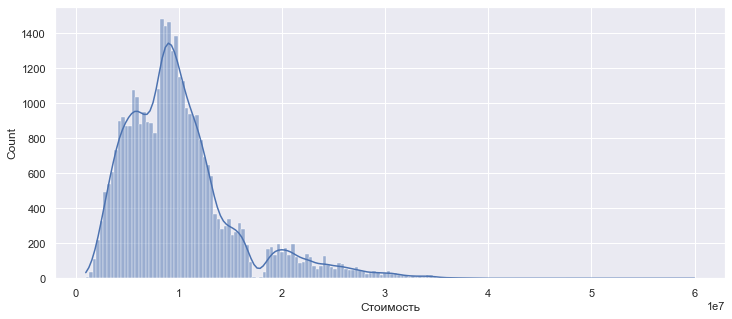

In [204]:
plt.figure(figsize=(12,5))
sns.histplot(data=y, kde=True)

In [218]:
def diff_days(date):
    """Функция преобразования даты в число дней от даты начала датасета"""
    
    days = (pd.to_datetime(date) - pd.to_datetime('20190101', format='%Y%m%d')).days
    
    return days

In [219]:
X['Дней'] = X['Дата обновления'].map(diff_days)

In [220]:
def fit_month_year(x, a, b):
    
    """Аппроксимация инфляции
    S[n] = a * ((1 + alpha)**n - 1) / (alpha)
    """ 
    
    return a * b ** (x)

[2.95919954e+06 1.00425360e+00]


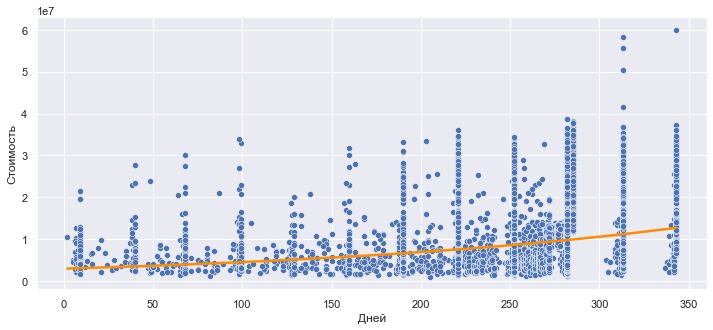

In [221]:
p0 = (1, 1)
pars, _ = scipy.optimize.curve_fit(
    fit_month_year, 
    X['Дней'],  
    y, 
    p0=p0)
print(pars)

plt.figure(figsize=(12,5))
ax = sns.scatterplot(x=X['Дней'], y=y)
ax = sns.lineplot(
    x=X['Дней'],
    y=fit_month_year(X['Дней'], *pars),
    color='darkorange',
    linewidth=2.5)
ax.set_ylabel('Стоимость')
plt.show()

In [225]:
X['Стоимость с инфляцией'] = X['Дней'].map(lambda row: fit_month_year(row, *pars))

In [226]:
X.isna().sum()

Объект продажи             0
Общая площадь              0
Этаж                       0
Этажей в доме              0
Парковка                   0
Количество комнат          0
Тип дома                   0
Высота потолков            0
Вид из окон                0
Расстояние до метро        0
Адрес                      0
Дата обновления            0
Высота неизвестнно         0
Высота менее 2.5-3 м       0
Высота более 3 м           0
Стоимость от расстояния    0
Широта                     0
Долгота                    0
Расстояние от центра       0
Дней                       0
Стоимость с инфляцией      0
dtype: int64

In [227]:
X.head()

,Объект продажи,Общая площадь,Этаж,Этажей в доме,Парковка,Количество комнат,Тип дома,Высота потолков,Вид из окон,Расстояние до метро,...,Дата обновления,Высота неизвестнно,Высота менее 2.5-3 м,Высота более 3 м,Стоимость от расстояния,Широта,Долгота,Расстояние от центра,Дней,Стоимость с инфляцией
0,Новостройка,42.20,2,3,Неизвестно,1.0,Кирпичный,0.0,0,1816.0,...,08.10.2019 13:56:39,1,0,0,4.714792e+06,55.719461,38.217599,0.363475,221,7.560753e+06
1,Новостройка,70.03,2,17,Подземная,2.0,Монолитный,0.0,0,480.0,...,11.10.2019 9:25:04,1,0,0,6.524899e+06,55.550157,37.387379,0.092906,313,1.117269e+07
2,Новостройка,76.47,11,17,Подземная,3.0,Монолитный,0.0,0,480.0,...,11.10.2019 6:45:06,1,0,0,6.524899e+06,55.550157,37.387379,0.092906,313,1.117269e+07
3,Новостройка,60.00,5,20,Неизвестно,2.0,Монолитный,0.0,1,120.0,...,11.10.2019 16:30:13,1,0,0,1.062781e+07,55.826742,37.435495,0.037994,313,1.117269e+07
4,Новостройка,65.20,2,5,Подземная,2.0,Монолитный,0.0,1,3490.0,...,09.10.2019 19:10:04,1,0,0,4.691463e+06,55.773611,37.254167,0.131092,252,8.624032e+06


In [228]:
y.shape

(36532,)

In [229]:
X.shape

(36532, 21)

In [230]:
X.to_csv(os.path.join('data', 'X_data.csv'))
y.to_csv(os.path.join('data', 'y_data.csv'))

---
### 3. Проверка итоговых данных 

In [4]:
X = pd.read_csv(os.path.join('data', 'X_data.csv'), index_col=0)
y = pd.read_csv(os.path.join('data', 'y_data.csv'), index_col=0)

In [5]:
X.head()

,Объект продажи,Общая площадь,Этаж,Этажей в доме,Парковка,Количество комнат,Тип дома,Высота потолков,Вид из окон,Расстояние до метро,...,Дата обновления,Высота неизвестнно,Высота менее 2.5-3 м,Высота более 3 м,Стоимость от расстояния,Широта,Долгота,Расстояние от центра,Дней,Стоимость с инфляцией
0,Новостройка,42.20,2,3,Неизвестно,1.0,Кирпичный,0.0,0,1816.0,...,08.10.2019 13:56:39,1,0,0,4.714792e+06,55.719461,38.217599,0.363475,221,7.560753e+06
1,Новостройка,70.03,2,17,Подземная,2.0,Монолитный,0.0,0,480.0,...,11.10.2019 9:25:04,1,0,0,6.524899e+06,55.550157,37.387379,0.092906,313,1.117269e+07
2,Новостройка,76.47,11,17,Подземная,3.0,Монолитный,0.0,0,480.0,...,11.10.2019 6:45:06,1,0,0,6.524899e+06,55.550157,37.387379,0.092906,313,1.117269e+07
3,Новостройка,60.00,5,20,Неизвестно,2.0,Монолитный,0.0,1,120.0,...,11.10.2019 16:30:13,1,0,0,1.062781e+07,55.826742,37.435495,0.037994,313,1.117269e+07
4,Новостройка,65.20,2,5,Подземная,2.0,Монолитный,0.0,1,3490.0,...,09.10.2019 19:10:04,1,0,0,4.691463e+06,55.773611,37.254167,0.131092,252,8.624032e+06


In [6]:
y.head()

,Стоимость
0,2850000
1,7073030
2,7799940
3,11700000
4,6055000


In [7]:
X.drop(['Объект продажи',
        'Адрес'], 
       axis=1, 
       inplace=True)

---
### Категориальные признаки

In [9]:
X_cat = X.select_dtypes(exclude=np.number).drop('Дата обновления', axis=1)

In [10]:
X_cat = pd.get_dummies(X_cat).drop(['Парковка_Неизвестно', 'Тип дома_Панельный'], axis=1)

In [11]:
X_cat.head()

,Парковка_Наземная,Парковка_Подземная,Тип дома_Кирпичный,Тип дома_Монолитно-кирпичный,Тип дома_Монолитный
0,0,0,1,0,0
1,0,1,0,0,1
2,0,1,0,0,1
3,0,0,0,0,1
4,0,1,0,0,1


---
### Числовые признаки

In [13]:
X_num = X.select_dtypes(include=np.number)

In [14]:
X_num = X_num.drop(['Высота потолков', 'Высота неизвестнно', 'Широта', 
        'Долгота', 'Расстояние до метро', 'Дней'], 
       axis=1)

In [ ]:
# sns.pairplot(X_num)

In [17]:
X_all = X_num.join(X_cat)

<AxesSubplot:>

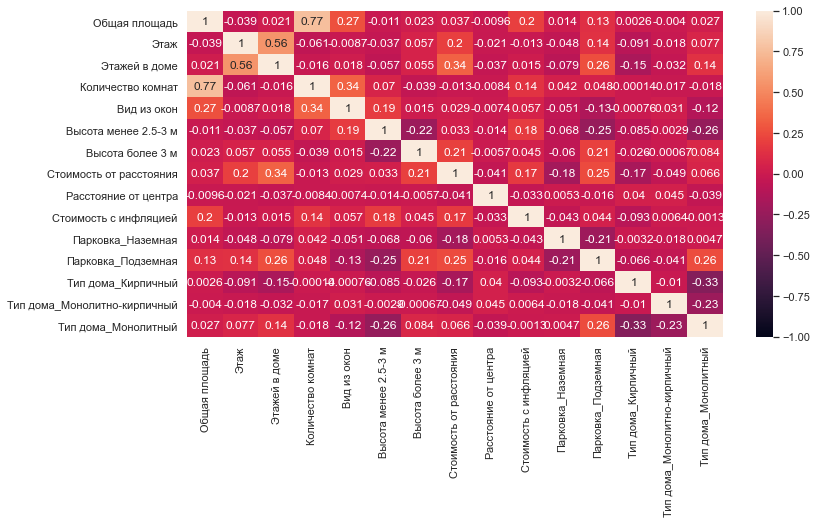

In [18]:
feature_correlation = X_all.corr(method='pearson')
plt.figure(figsize=(12,6))
sns.heatmap(feature_correlation, annot=True, vmin=-1, vmax=1)

In [19]:
X_all.to_csv(os.path.join('data', 'X_data_preprocessed.csv'))
# y.to_csv(os.path.join('data', 'y_data.csv'))